In [2]:
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy

## Sample entropy function

In [2]:
import numpy as np

def sampen_wiki(L, m, r):
    N = len(L)
    B = 0.0
    A = 0.0
    
    
    # Split time series and save all templates of length m
    xmi = np.array([L[i : i + m] for i in range(N - m)])
    xmj = np.array([L[i : i + m] for i in range(N - m + 1)])

    # Save all matches minus the self-match, compute B
    B = np.sum([np.sum(np.abs(xmii - xmj).max(axis=1) <= r) - 1 for xmii in xmi])

    # Similar for computing A
    m += 1
    xm = np.array([L[i : i + m] for i in range(N - m + 1)])

    A = np.sum([np.sum(np.abs(xmi - xm).max(axis=1) <= r) - 1 for xmi in xm])
    
    print(B, A)

    # Return SampEn
    return -np.log(A / B)

In [200]:
def coarse_scale(total_signal, gamma, downscale = False):
    #total signal is a N x 1 vector!
    
    if len(total_signal.shape) < 1:
        total_signal = total_signal.reshape(-1, 1)
    
    elif total_signal.shape[0] == 1: #row vector
        total_signal = total_signal.T
    
    if downscale:
        print("Please do not use downscale.")
        raise SystemExit
        
        #return total_signal[range(0, len(total_signal), gamma)]
    
    else:    

        N, p = total_signal.shape

        new_size = int(N / gamma)

        new_signal = np.zeros((new_size, p))

        for i in range(p):
            #extract ith signal
            signal = total_signal[: new_size * gamma, i] #Cut off ends if it is not even

            #resize
            signal = signal.reshape(new_size, gamma)

            new_signal[:, i] = np.mean(signal, axis = 1)
            
        return new_signal 


def SampEn(data, m, r, tau = 1, gamma = 1, normalise_flag = False, downscale_flag = False):
    #r is a percentage
    #tau controls the time delay
    #gamma specifies if you compute the coarse grained signal or not
    
    signal = deepcopy(data)
    
    #Normalise signal and calculate r_tol
    if normalise_flag:
        
        signal = (signal - np.mean(signal)) / np.std(signal)
        r_tol = r
    
    else:
        #Calculate r_tol
        r_tol = r * np.std(signal)
    
    if len(signal.shape) > 1:
        print("You have multivariate data!")
        multi_flag = True
        N, p = signal.shape
        
    else:
        multi_flag = False
        signal = signal.reshape(-1, 1) #Make as if it was multivariate
    
    if gamma > 1:
        signal = coarse_scale(signal, gamma, downscale_flag)

        print("New shape: {}".format(signal.shape))

    N = len(signal)
    B = 0.0
    A = 0.0
    
    #Create data matrix for m and m + 1 case
    #Bmat = np.zeros(( int((N - m) / tau), m))
    #Amat = np.zeros(( int((N - m) / tau), m + 1))
    
    #for i in range(0, m, 1):
    #    range1 = range(i, N - m + i, tau)
        
    #    Bmat[:, i] = signal[range1]
    #    Amat[:, i] = signal[range1]
    
    #Add on last column to Amat
    #Amat[:, -1] = signal[m:]
    
    #Compute B vectors
    start = 0
    end = start + (m - 1) * tau + 1
    
    B = []
    cnt = 0
    while end <= N:
        #print(start, end, cnt)
        B.append(np.array([signal[range(start, end, tau), i] for i in range(signal.shape[1]) ]).reshape(-1))
        
        start += 1
        end = start + (m - 1) * tau + 1
        cnt += 1
    
    Bmat = np.array(B)
    
    #Compute A vectors, m + 1 case
    start = 0
    end = start + (m) * tau + 1
    
    A = []
    cnt = 0
    
    while end <= N:
        A.append(np.array([signal[range(start, end, tau), i] for i in range(signal.shape[1]) ]).reshape(-1))
        
        start += 1
        end = start + (m) * tau + 1
        cnt += 1
    
    Amat = np.array(A)
    
    #print(Bmat, Bmat.shape)
    #print(Amat, Amat.shape)
    
    #Loop through rows
    B_count = np.zeros(Bmat.shape[0])
    A_count = np.zeros(Amat.shape[0])
    
    #B calculation
    for i in range(0, Bmat.shape[0], 1):
        abs_difference = np.abs(Bmat - Bmat[i, :])
        
        distance_B = np.max(abs_difference, axis = 1)
        #Adjust ith term to be larger than r_tol so that it is not included in the sum
        distance_B[i] = r_tol + 10
        
        #print(distance_B, np.sum(distance_B  <= r_tol))
        
        B_count[i] = ( np.sum(distance_B  <= r_tol) )# / (N - m * tau - 1)
    
    #A calculation
    for i in range(0, Amat.shape[0], 1):
        abs_difference = np.abs(Amat - Amat[i, :])
        distance_A = np.max(abs_difference, axis = 1)
        
        #Adjust ith term to be larger than r_tol so that it is not included in the sum
        distance_A[i] = r_tol + 10
        
        #print(distance_A, np.sum(distance_A  <= r_tol))
        
        A_count[i] = ( np.sum(distance_A  <= r_tol) )# / (N - m * tau - 1)
    
    B = np.sum(B_count)
    A = np.sum(A_count)

    return -np.log(A / B)


#SampEn(a, 2, 0.2, tau = 1, gamma = 1, normalise_flag = False, downscale_flag = False)

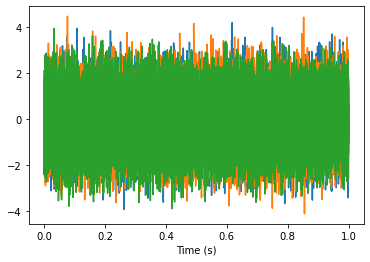

You have multivariate data!


C:\Users\RYANB~1.LAP\AppData\Local\Temp/ipykernel_13964/1975998633.py:150: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)


You have multivariate data!
New shape: (15000, 3)
You have multivariate data!
New shape: (10000, 3)
You have multivariate data!
New shape: (7500, 3)
You have multivariate data!
New shape: (6000, 3)
You have multivariate data!
New shape: (5000, 3)
You have multivariate data!
New shape: (4285, 3)
You have multivariate data!
New shape: (3750, 3)
You have multivariate data!
New shape: (3333, 3)
You have multivariate data!
New shape: (3000, 3)
You have multivariate data!
New shape: (2727, 3)
You have multivariate data!
New shape: (2500, 3)
You have multivariate data!
New shape: (2307, 3)
You have multivariate data!
New shape: (2142, 3)
You have multivariate data!
New shape: (2000, 3)
You have multivariate data!
New shape: (1875, 3)
You have multivariate data!
New shape: (1764, 3)
You have multivariate data!
New shape: (1666, 3)
You have multivariate data!
New shape: (1578, 3)
You have multivariate data!
New shape: (1500, 3)


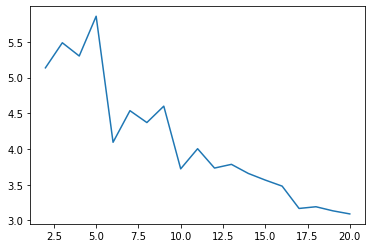

In [207]:
Fs = 30000
t =  np.arange(0, 1, 1 / Fs)
signal = np.random.randn(Fs) #np.sin(2 * np.pi * t)#

signal = np.vstack((np.random.randn(Fs), np.random.randn(Fs), np.random.randn(Fs))).T

plt.figure()
plt.plot(t, signal)
plt.xlabel("Time (s)")
plt.show()

gamma_range = range(1, 21, 1)
SEn_vals = []

for gamma_loop in gamma_range:
    SEn_vals.append(SampEn(signal, 2, 0.15, tau = 1, gamma = gamma_loop, normalise_flag = False, downscale_flag=False))

plt.figure()
plt.plot(gamma_range, SEn_vals)
plt.show()


## Variational Mode Decomposition

In [52]:
%matplotlib notebook

def VMD(signal, alpha, tau, K, DC, init, tol = 1e-6):
    
    Alpha = np.ones(K) * alpha #balancing parameter
    #tau = time-step dual ascent
    #K = number of modes to be recovered
    # DC = True if the first mode is a DC component
    eps = 2.220446049250313e-016
    
    #Set maximum number of iterations
    N = 500
    
    #original parameters
    save_T = len(signal)
    Fs = 1/save_T
    
    omega_plus = np.zeros((N, K))
    
    if init == 0:
        pass #all omegas are zero
    
    if init == 1:
        omega_plus[0, :] = [(0.5 / K)*(i) for i in range(K)] #all omegas are uniformly distributed
    
    if init == 2:
        omega_plus[0, :] = np.sort(np.exp(np.log(Fs) + (np.log(0.5 / Fs))) * np.random.random(size = K)) #all omegas are randomly selected in [0, 1]
        
    if DC:
        omega_plus[0, 0] = 0
    
    #Mirror signal
    T = save_T
    
    f_mirror = np.zeros(2 * T)
    f_mirror[:T//2] = signal[ : T // 2][::-1]
    f_mirror[T//2 : 3 * T //2 ] = signal
    f_mirror[3 * T //2 : ] = signal[T//2 :][::-1]
    
    f = f_mirror
    
    plt.figure()
    plt.plot(f)
    plt.show()
    
    #Extend time domain
    T *= 2
    t = np.arange(1, T + 1, 1) / T
    
    #spectral discretisation
    freqs = t - 0.5 - 1/T
    
    #calculate spectral information
    f_hat = np.fft.fftshift((np.fft.fft(f)))
    f_hat_plus = f_hat
    
    #Turn off one half
    f_hat_plus[:T//2] = 0
    
    u_hat_plus = np.zeros((N, len(freqs), K),dtype=np.complex_) #Store u_hat in frequency (complex) domain for all iterations
    
    #Set up lambda variables
    lambda_hat = np.zeros((N, len(freqs)), dtype=np.complex_)
    
    #initialise other stuff for loops
    uDiff = tol + eps
    n = 0
    sum_uk = 0
    
    while uDiff > tol and n < N - 2:
        
        k = 0
        
        sum_uk += u_hat_plus[n, :, K - 1] - u_hat_plus[n, :, k] 
        #Think about loop restart (all zero initially)
        #You will have subracted u_hat_plus[K], so add it back on and then subtract u_hat_plus[0]
        
        #U update @ k = 0
        u_hat_plus[n + 1, :, k] = (f_hat_plus - sum_uk - lambda_hat[n, :] / 2) / (1 +  2 * Alpha[k] * (freqs - omega_plus[n, k])**2)
        
        #Omega update @ k = 0 #freqs[T // 2 : T] is the positive half of the integration
        if not DC:
            omega_plus[n + 1, k] = np.sum(freqs[T//2 :] * (np.abs(u_hat_plus[n + 1, T//2 :, k])**2)) / np.sum(np.abs(u_hat_plus[n + 1, T // 2 :, k])**2)
            
        for k in range(1, K, 1):
            
            sum_uk += u_hat_plus[n + 1, :, k - 1] - u_hat_plus[n, :, k]
            
            #U update @ k = 0
            u_hat_plus[n + 1, :, k] = (f_hat_plus - sum_uk - lambda_hat[n, :] / 2) / (1 + 2 * Alpha[k] * (freqs - omega_plus[n, k])**2)
            
            #Omega update @ k
            omega_plus[n + 1, k] = np.sum(freqs[T//2 :] * (np.abs(u_hat_plus[n + 1, T//2:, k])**2)) / np.sum(np.abs(u_hat_plus[n + 1, T // 2 :, k])**2)
        
        #Dual ascent
        lambda_hat[n + 1, :] = lambda_hat[n, :] + tau * (np.sum(u_hat_plus[n + 1, :, :], axis = 1) - f_hat_plus)
        
        #loop counter 
        n += 1
        
        #convergence
        uDiff = eps
        
        for i in range(K):
            uDiff += 1 / T * np.sum(np.abs(u_hat_plus[n, :, i] - u_hat_plus[n - 1, :, i])**2)

    #Clean up and post-processing
    N = min(N, n)

    print("Terminated after {} iterations".format(N))
    
    omega = omega_plus[1:N, :]
    
    #Reconstruct signals from frequency
    u_hat = np.zeros((T, K),dtype=np.complex_)
    u = np.zeros((T // 2, K))
    
    for i in range(K): #Take u_i[positive half] and make properly defined
        
        #Arrange first half
        u_hat[T//2:, i] = u_hat_plus[N, T//2:, i]
        #Arrange second half
        u_hat[range(T//2, 0, -1), i] = u_hat_plus[N, T//2:, i] #compute conjegate and reverse
        #Set first term
        u_hat[0, i] = np.conjugate(u_hat_plus[N, -1, i]) #Compute starting term

        
        #Shift, compute IFFT and then select non-mirrored bit!
        u[:, i] = np.real(np.fft.ifft(np.fft.ifftshift(u_hat[:, i])))[T//4 : 3*T//4]
    
    #Recompute u_hat
    u_hat = np.zeros((T // 2, K),dtype=np.complex_)
    
    for i in range(K):
        u_hat[:, i] = np.fft.fftshift(np.fft.fft(u[:, i]))
    
    return u, u_hat, omega


In [25]:
len(range(2000//2, 0, -1))

1000

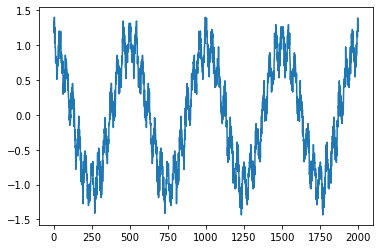

Terminated after 48 iterations


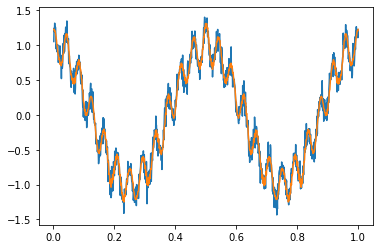

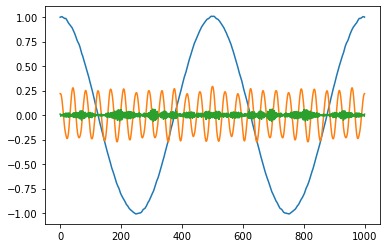

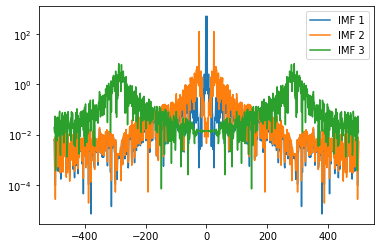

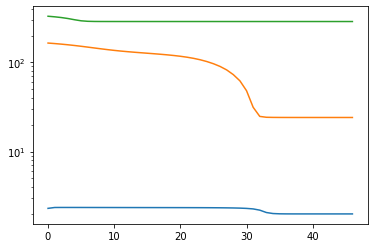

In [124]:

f1 = 2
f2 = 24
f3 = 288
Fs = 1000
time = np.arange(1, Fs + 1, 1) / Fs

v1 = np.cos(2 * np.pi * f1 * time)
v2 = 1/4 * np.cos(2 * np.pi * f2 * time)
v3 = 1/16 * np.cos(2 * np.pi * f3 * time)

x4 = v1 + v2 + v3 + np.random.randn(len(time)) * 0.1

IMF, U_IMF, Omega = VMD(x4, alpha = 1000, tau = 0, K = 3, DC = False, init = 1, tol = 1e-7)

plt.figure()
plt.plot(time, x4)
plt.plot(time, np.sum(IMF, axis = 1))
plt.show()

plt.figure()
for i in range(IMF.shape[1]):
    plt.plot(IMF[:, i])
plt.show()

plt.figure()
#plt.semilogy(np.fft.fftshift(np.fft.fftfreq(len(time), 1/Fs)), np.abs(np.fft.fftshift(np.fft.fft(x4))), label = "actual signal")
for i in range(U_IMF.shape[1]):
    plt.semilogy(np.fft.fftshift(np.fft.fftfreq(len(time), 1/Fs)), np.abs(U_IMF[:, i]), label = "IMF {}".format(i + 1))
plt.legend()
plt.show()

plt.figure()
for i in range(Omega.shape[1]):
    plt.semilogy(Omega[:, i] * Fs)
plt.show()

## Multivariate VMD

In [95]:

def MVMD(signals, alpha, tau, K, DC, init, tol = 1e-6):
    
    Alpha = np.ones(K) * alpha #balancing parameter
    #tau = time-step dual ascent
    #K = number of modes to be recovered
    # DC = True if the first mode is a DC component
    eps = 2.220446049250313e-016
    
    #Set maximum number of iterations
    N = 500
    
    #original parameters
    save_T, C = signals.shape
    
    print("There are {} signals.".format(C))
    
    Fs = 1/save_T
    
    omega_plus = np.zeros((N, K))
    
    if init == 0:
        pass #all omegas are zero
    
    if init == 1:
        omega_plus[0, :] = [(0.5 / K)*(i) for i in range(K)] #all omegas are uniformly distributed
    
    if init == 2:
        omega_plus[0, :] = np.sort(np.exp(np.log(Fs) + (np.log(0.5 / Fs))) * np.random.random(size = K)) #all omegas are randomly selected in [0, 1]
        
    if DC:
        omega_plus[0, 0] = 0
    
    #Mirror signal
    T = save_T
    
    f = np.zeros((2 * T, C))
    
    for c in range(C):
        f_mirror = np.zeros(2 * T)
        f_mirror[:T//2] = signals[ : T // 2, c][::-1]
        f_mirror[T//2 : 3 * T //2] = signals[:, c]
        f_mirror[3 * T //2 :] = signals[T//2 :, c][::-1]

        f[:, c] = f_mirror
    
    #Extend time domain
    T *= 2
    t = np.arange(1, T + 1, 1) / T
    
    #spectral discretisation
    freqs = t - 0.5 - 1/T
    
    #calculate spectral information
    f_hat_plus = np.zeros((T, C),dtype=np.complex_)
    
    for c in range(C):
        f_hat = np.fft.fftshift((np.fft.fft(f[:, c])))
        f_hat_plus[:, c] = f_hat
    
    #Turn off one half
    f_hat_plus[:T//2, :] = 0
    
    u_hat_plus = np.zeros((N, len(freqs), K, C),dtype=np.complex_) #Store u_hat in frequency (complex) domain for all iterations
    
    #Set up lambda variables
    lambda_hat = np.zeros((N, len(freqs), C), dtype=np.complex_)
    
    #initialise other stuff for loops
    uDiff = tol + eps
    n = 0
    sum_uk = np.zeros_like(f, dtype=np.complex_)
    
    while uDiff > tol and n < N - 2:
        
        
        ##################
        #U update
        ##################
        for c in range(C):
            k = 0
            #Think about loop restart (all zero initially)
            #You will have subracted u_hat_plus[K], so add it back on and then subtract u_hat_plus[0]
            
            sum_uk[:, c] += u_hat_plus[n, :, K - 1, c] - u_hat_plus[n, :, k, c] 
            
            #U update @ k = 0
            u_hat_plus[n + 1, :, k, c] = (f_hat_plus[:, c] - sum_uk[:, c] - lambda_hat[n, :, c] / 2) / (1 +  2 * Alpha[k] * (freqs - omega_plus[n, k])**2)

            for k in range(1, K, 1):

                sum_uk[:, c] += u_hat_plus[n + 1, :, k - 1, c] - u_hat_plus[n, :, k, c]

                #U update @ k = 0
                u_hat_plus[n + 1, :, k, c] = (f_hat_plus[:, c] - sum_uk[:, c] - lambda_hat[n, :, c] / 2) / (1 + 2 * Alpha[k] * (freqs - omega_plus[n, k])**2)
        
        ##################
        #OMEGA update
        ##################
        for k in range(K):
            omega_term = 0
            
            #Omega update @ k = 0 #freqs[T // 2 : T] is the positive half of the integration
            for c in range(C):
                upper_term = np.sum(freqs[T//2 :] * (np.abs(u_hat_plus[n + 1, T//2 :, k, c])**2))
                lower_term = np.sum(np.abs(u_hat_plus[n + 1, T // 2 :, k])**2)
                omega_term +=  upper_term / lower_term
            
            if k == 0 and DC:
                omega_term = 0
                

            omega_plus[n + 1, k] = omega_term
        
        ##############
        #Dual ascent
        ##############
        for c in range(C):
            lambda_hat[n + 1, :, c] = lambda_hat[n, :, c] + tau * (np.sum(u_hat_plus[n + 1, :, :, c], axis = 1) - f_hat_plus[:, c])

        #loop counter 
        n += 1
        
        #convergence
        uDiff = eps
        
        for c in range(K):
            for c in range(C):
                uDiff += 1 / T * np.sum(np.abs(u_hat_plus[n, :, i, c] - u_hat_plus[n - 1, :, i, c])**2)
        
    #Clean up and post-processing
    N = min(N, n)

    print("Terminated after {} iterations (uDiff = {})".format(N, uDiff))
    
    omega = omega_plus[1:N, :]
    
    #Reconstruct signals from frequency
    u_hat = np.zeros((T, K, C),dtype=np.complex_)
    u = np.zeros((T // 2, K, C))
    
    for k in range(K): #Take u_i[positive half] and make properly defined
        
        for c in range(C):
            #Arrange first half
            u_hat[T//2:, k, c] = u_hat_plus[N, T//2:, k, c]
            #Arrange second half
            u_hat[range(T//2, 0, -1), k, c] = u_hat_plus[N, T//2:, k, c] #compute conjegate and reverse
            #Set first term
            u_hat[0, k, c] = np.conjugate(u_hat_plus[N, -1, k, c]) #Compute starting term


            #Shift, compute IFFT and then select non-mirrored bit!
            u[:, k, c] = np.real(np.fft.ifft(np.fft.ifftshift(u_hat[:, k, c])))[T//4 : 3*T//4]
    
    #Recompute u_hat
    u_hat = np.zeros((T // 2, K, C),dtype=np.complex_)
    
    for k in range(K):
        for c in range(C):
            u_hat[:, k, c] = np.fft.fftshift(np.fft.fft(u[:, k, c]))
    
    return u, u_hat, omega

<IPython.core.display.Javascript object>


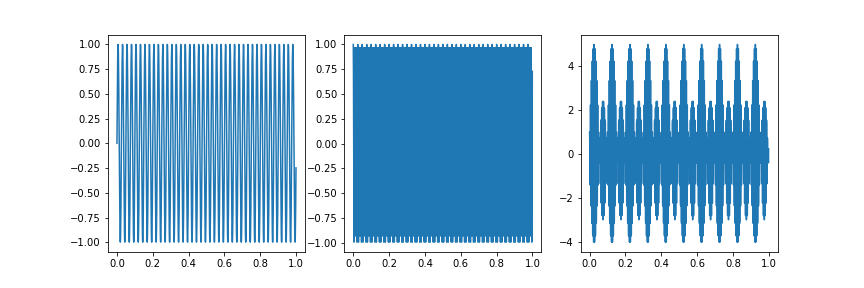

(3, 1000)
[[1.57961132 0.92024061 1.50141949]
 [0.92024061 0.72174914 0.77070003]
 [1.50141949 0.77070003 1.56376338]]


<IPython.core.display.Javascript object>


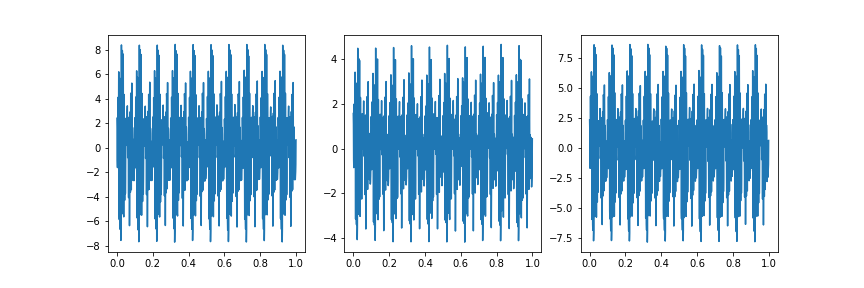

<IPython.core.display.Javascript object>


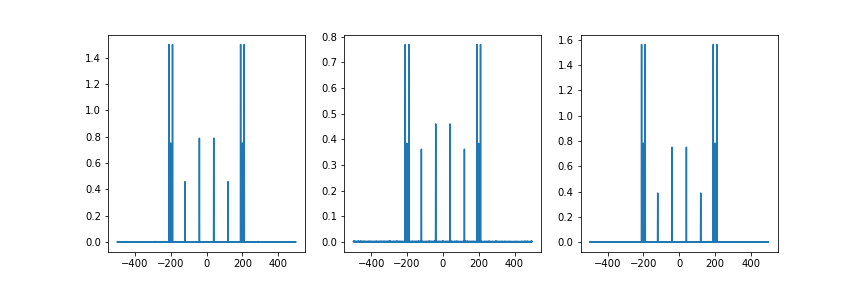

In [270]:
T = 1
Fs = 1000
f1 = 40
f2 = 120
f3 = 200
f4 = 10

time = np.arange(0, T, 1/Fs)

x1 = np.sin(2 * np.pi * f1 * time)
x2 = np.cos(2 * np.pi * f2 * time)
x3 = np.cos(2 * np.pi * f3 * time) * (1 + 4 * np.sin(2 * np.pi * f4 * time))

fig, ax = plt.subplots(1, 3, figsize = (12, 4))
ax = ax.flatten()
ax[0].plot(time, x1)
ax[1].plot(time, x2)
ax[2].plot(time, x3)
plt.show()

X = np.vstack((x1, x2, x3))
print(X.shape)

R = np.random.rand(3, 3)
R = np.dot(R, R.T)

print(R)

S = np.dot(R, X) + np.random.randn(3, len(time)) * 0.05
S = S.T

fig, ax = plt.subplots(1, 3, figsize = (12, 4))
ax = ax.flatten()
ax[0].plot(time, S[:, 0])
ax[1].plot(time, S[:, 1])
ax[2].plot(time, S[:, 2])
plt.show()

freq = np.fft.fftfreq(Fs, 1/Fs)

fig, ax = plt.subplots(1, 3, figsize = (12, 4))
ax = ax.flatten()
ax[0].plot(freq, 1 / Fs * np.abs(np.fft.fft(S[:, 0])))
ax[1].plot(freq, 1 / Fs * np.abs(np.fft.fft(S[:, 1])))
ax[2].plot(freq, 1 / Fs * np.abs(np.fft.fft(S[:, 2])))
plt.show()


There are 3 signals.
Terminated after 95 iterations (uDiff = 9.675900187921722e-08)
(1000, 10, 3)


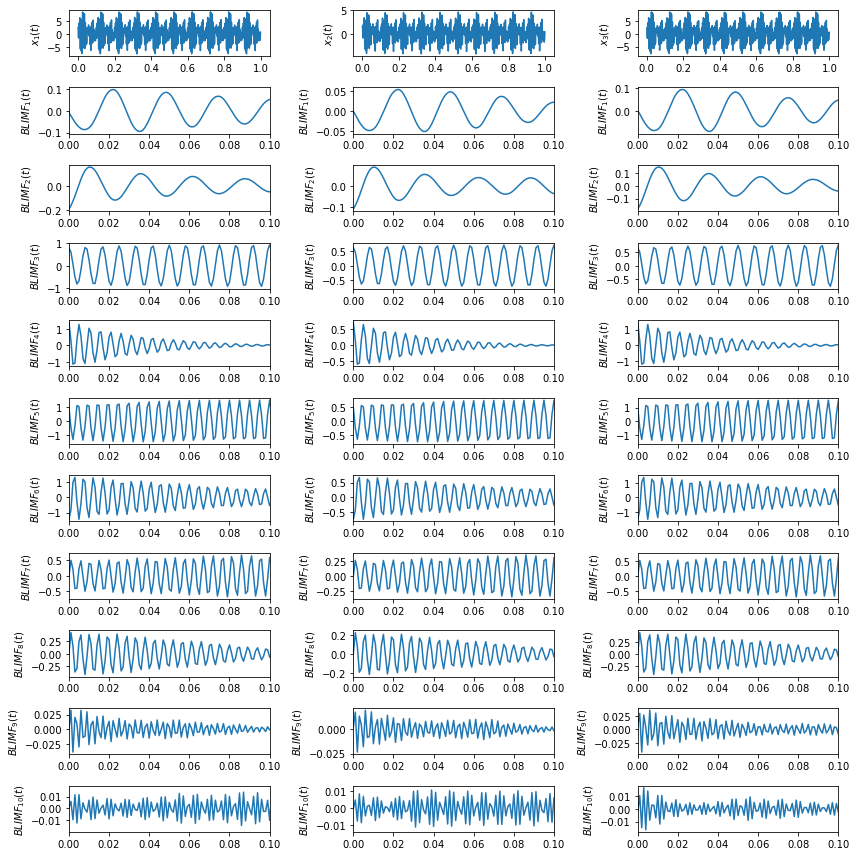

In [271]:
%matplotlib inline

K =  10
u, u_hat, omega = MVMD(S, alpha = 10000, tau = 0, K = K, DC = False, init = 1, tol = 1e-7)

print(u.shape)

fig, ax = plt.subplots(K + 1, S.shape[1], figsize = (12, 12))
ax = ax.flatten()

ax[0].plot(time, S[:, 0])
ax[0].set_ylabel(r"$x_1(t)$")

ax[1].plot(time, S[:, 1])
ax[1].set_ylabel(r"$x_2(t)$")

ax[2].plot(time, S[:, 2])
ax[2].set_ylabel(r"$x_3(t)$")

cnt = 3
for k in range(K):
    for c in range(S.shape[1]):
    
        
        ax[cnt].plot(time, u[:, k, c])
        ax[cnt].set_ylabel(r"$BLIMF_{}(t)$".format("{" + str(k + 1) + "}"))
        ax[cnt].axis([0, 0.1, None, None])
        cnt += 1
        
plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


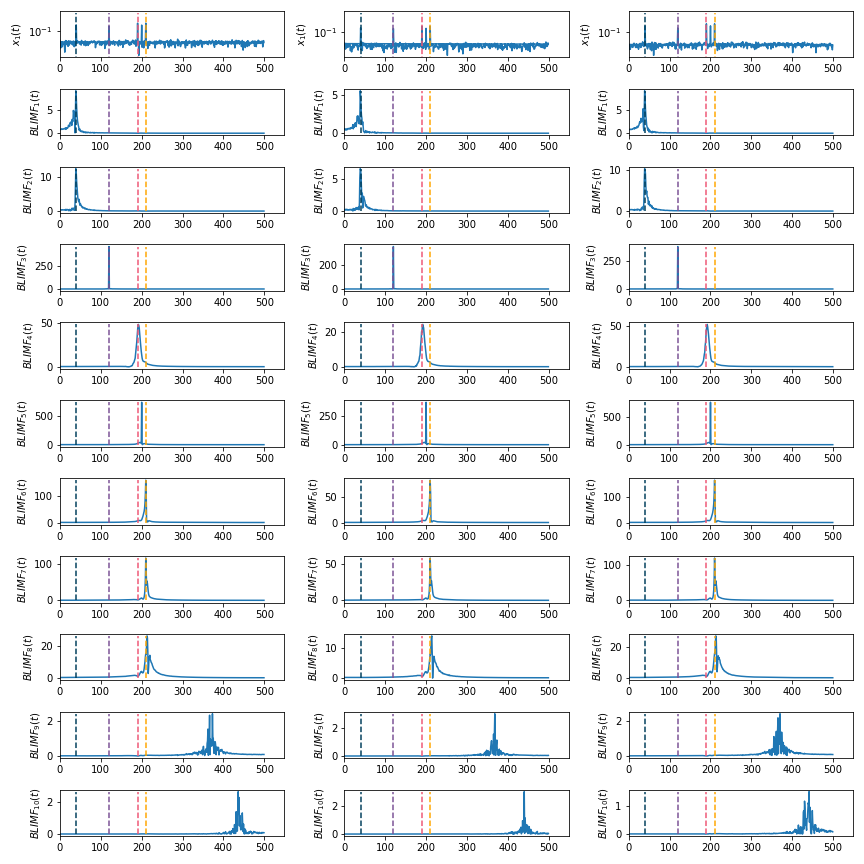

In [272]:
freq = np.fft.fftfreq(Fs, 1/Fs)
%matplotlib notebook
fig, ax = plt.subplots(K + 1, S.shape[1], figsize = (12, 12))
ax = ax.flatten()

for cnt in range(S.shape[1]):
    ax[cnt].semilogy(freq, 1 / Fs * np.abs(np.fft.fft(S[:, cnt])))
    ax[cnt].set_ylabel(r"$x_1(t)$")
    
    ax[cnt].plot([f1, f1], [0, np.max(amp)], color = "#003f5c", linestyle = "--")
    ax[cnt].plot([f2, f2], [0, np.max(amp)], color = "#7a5195", linestyle = "--")
    ax[cnt].plot([f3 - f4, f3 - f4], [0, np.max(amp)], color = "#ef5675", linestyle = "--")
    ax[cnt].plot([f3 + f4, f3 + f4], [0, np.max(amp)], color = "#ffa600", linestyle = "--")
    ax[cnt].axis([0, None, None, None])


cnt = 3
for k in range(K):
    for c in range(S.shape[1]):
    
        amp = np.abs(u_hat[:, k, c])
        ax[cnt].plot(np.fft.fftshift(freq), amp)
        ax[cnt].set_ylabel(r"$BLIMF_{}(t)$".format("{" + str(k + 1) + "}"))
        
        ax[cnt].plot([f1, f1], [0, np.max(amp)], color = "#003f5c", linestyle = "--")
        ax[cnt].plot([f2, f2], [0, np.max(amp)], color = "#7a5195", linestyle = "--")
        ax[cnt].plot([f3 - f4, f3 - f4], [0, np.max(amp)], color = "#ef5675", linestyle = "--")
        ax[cnt].plot([f3 + f4, f3 + f4], [0, np.max(amp)], color = "#ffa600", linestyle = "--")
        ax[cnt].axis([0, None, None, None])
        cnt += 1
        
plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


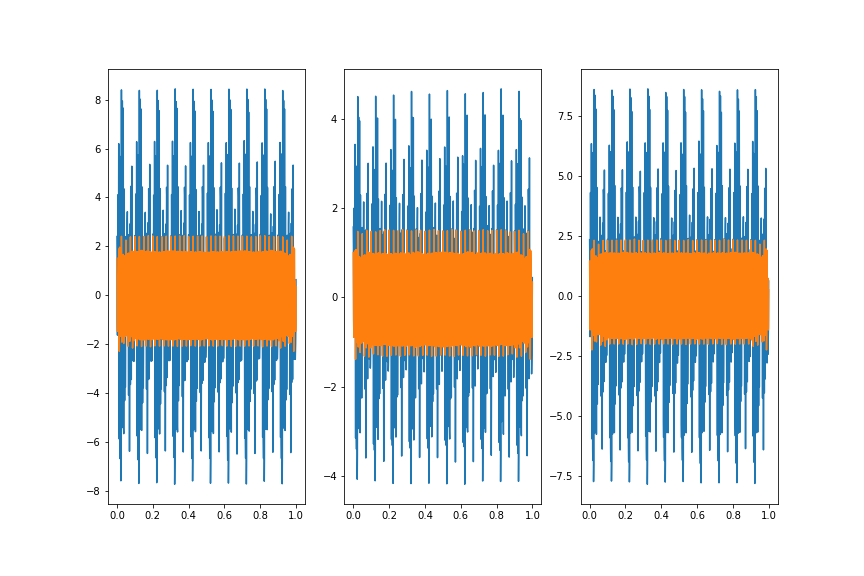

In [273]:
fig, ax = plt.subplots(1, S.shape[1], figsize = (12, 8))
ax = ax.flatten()

ax[0].plot(time, S[:, 0])
ax[1].plot(time, S[:, 1])
ax[2].plot(time, S[:, 2])

cnt = 0
for c in range(S.shape[1]):
    signal_recon = 0
    for k in range(K):
        
        signal_recon += u[:, k, c]
    
    ax[cnt].plot(time, signal_recon)
    cnt += 1

plt.show()
